In [77]:
from pandas_datareader import data as pdr
import numpy as np
from numpy import arange
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV as rcv
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn import mixture as mix
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn
from IPython import get_ipython
import datetime
import yfinance as yf
import csv

In [2]:
n = 3 # DAYS IN THE FUTURE TO PREDICT


df = pdr.DataReader('ETH-USD',data_source='yahoo' ,start='2020-01-01',end=datetime.date.today())
df = df[['Open']]#,'High','Low','Close','Volume']] 

# YF FEATURES
yf_features = ['SPY','VXX','BTC-USD','QQQ','XLP','TSLA','GLD','TBT','DOGE-USD','LTC-USD','XRP-USD','ADA-USD','LTPZ',]
for val in yf_features:
    df = df.join(pdr.DataReader(val,data_source='yahoo',start='2020-01-01',end=datetime.date.today())[['Close','Volume']].rename(columns={"Close":val+"Close", "Volume":val+"Volume"}))
df = df[:-1]

# FRED FEATURES
fred_features = ['GS10', 'CPIAUCSL']
for val in fred_features:
    df = df.join(pdr.get_data_fred(val,start='2020-01-01'))

df.insert(0,'Future',df['Open'].shift(-n))
# df['Future'] = df['Open'].shift(-1)
df

,Future,Open,SPYClose,SPYVolume,VXXClose,VXXVolume,BTC-USDClose,BTC-USDVolume,QQQClose,QQQVolume,...,LTC-USDClose,LTC-USDVolume,XRP-USDClose,XRP-USDVolume,ADA-USDClose,ADA-USDVolume,LTPZClose,LTPZVolume,GS10,CPIAUCSL
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,134.168518,129.630661,NaN,NaN,NaN,NaN,7200.174316,1.856566e+10,NaN,NaN,...,42.017719,2.782992e+09,0.192667,1.041134e+09,0.033458,2.294837e+07,NaN,NaN,1.76,258.687
2020-01-02,135.072098,130.820038,324.869995,59151200.0,58.040001,7078100.0,6985.470215,2.080208e+10,216.160004,30969400.0,...,39.823013,2.759827e+09,0.188043,1.085351e+09,0.032751,2.084393e+07,73.199997,136900.0,NaN,NaN
2020-01-03,136.305542,127.411263,322.410004,77709700.0,61.160000,12039150.0,7344.884277,2.811148e+10,214.179993,27518900.0,...,42.415573,3.260961e+09,0.193521,1.270017e+09,0.034180,3.016264e+07,74.070000,113200.0,NaN,NaN
2020-01-04,144.311996,134.168518,NaN,NaN,NaN,NaN,7410.656738,1.844427e+10,NaN,NaN,...,43.326607,2.843193e+09,0.194355,9.993316e+08,0.034595,2.953578e+07,NaN,NaN,NaN,NaN
2020-01-05,143.487823,135.072098,NaN,NaN,NaN,NaN,7411.317383,1.972507e+10,NaN,NaN,...,43.553207,3.017148e+09,0.195537,1.168068e+09,0.034721,2.147918e+07,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-12,3309.844238,3238.449951,471.019989,67605400.0,17.629999,43270200.0,43949.101562,3.349994e+10,387.350006,54576400.0,...,141.737198,8.815853e+08,0.799548,1.976048e+09,1.304535,1.651269e+09,85.639999,348400.0,NaN,NaN
2022-01-13,3330.387207,3372.104980,464.529999,91173100.0,18.740000,59111100.0,42591.570312,4.769114e+10,377.660004,77994000.0,...,136.636520,8.864340e+08,0.768328,1.578656e+09,1.233161,2.022506e+09,85.989998,133200.0,NaN,NaN
2022-01-14,NaN,3248.648682,464.720001,95849600.0,18.450001,86607200.0,43099.699219,2.357740e+10,380.010010,80076100.0,...,144.724915,1.204658e+09,0.774297,1.576112e+09,1.290926,1.855981e+09,84.790001,156200.0,NaN,NaN


In [3]:
df2 = df # backup

## Lasso and Ridge Regression

In [4]:
# Fills in NaN values for LASSO regression
df2 = df2.fillna(method ='ffill')[1:]
df2 = df2.values

X, y = df2[:, 1:], df2[:, 0]

# define model evaluation method via repeated K-Fold Cross Validation
cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

Below we try both Ridge and Lasso regressions in order to make our predictions. Both estimators shrink the estimator to zero, however, Ridge penalizes large squared values of the coefficients. Then we go ahead and minimize the penalized sum of squared residuals:

$$\min\{\sum_{i=1}^n(Y_i - X_i^{'}b)^2 + \lambda_{Ridge}\sum_{j=1}^{k}b_j^2\}$$

Similarly, Lasso shrinks the estimate towards zero by penalizing absolute values of the coefficients as shown below:

$$\min\{\sum_{i=1}^n(Y_i - X_i^{'}b)^2 + \lambda_{Lasso}\sum_{j=1}^{k}|b_j|\}$$

In both cases we $10$-fold cross validation in order to determine the $\lambda_{Ridge}$ and $\lambda_{Lasso}$ which yield the lowest MSPE$(\lambda_{Ridge})$ and MSPE$(\lambda_{Lasso})$ respectively.

It is worth noting that Lasso looks very similar to Ridge, but turns out to have one very special property: Lasso
tends to set many the $\hat{\beta}$’s exactly to $0$. Ridge shrinks them relative to OLS, but doesn’t shrink
them all the way to zero.

This feature means that Lasso can work especially well when in reality many of the predictors are irrelevant (but we don’t know which ones).  

DUBIOUS: This indicates a reason that Lasso does in fact provides better estimates in our goal of estimating ETH-USD's open price.



In [5]:
# define model
model = LassoCV(alphas =arange(0.01, 20, 0.01), cv = cv, n_jobs = -1, tol = 1)
model2 = make_pipeline(StandardScaler(with_mean=False), RidgeCV(alphas =arange(0.01, 20, 0.01), cv = cv))

# fit model
model.fit(X, y)
model2.fit(X, y)

# summarize chosen configuration
print('alpha: %f' % model.alpha_)
# Not sure how to print this alpha
print('alpha: %f' % model2[1].alpha_)

alpha: 0.010000
alpha: 0.490000


In [6]:
# Price prediction n days from now using LASSO CV
print("Lasso prediction: " , model.predict([df2[-1][1:]])[0])

Lasso prediction:  3281.8295390011085


In [7]:
# Price prediction n days from now using RIDGE CV
print("Ridge prediction: " , model2.predict([df2[-1][1:]])[0])

Ridge prediction:  3356.6386254844756


In [8]:
# Today's price prediction from n days ago using LASSO CV
print("Lasso prediction: " , model.predict([df2[-n-1][1:]])[0])
print("Percent error: " , 100*(df2[-n-1][0] - model.predict([df2[-n-1][1:]])[0])/df2[-n-1][0] , "%")

Lasso prediction:  3347.450381002067
Percent error:  -0.5123480517458289 %


In [9]:
# Today's price prediction from n days ago using Ridge CV
print("Ridge prediction: " , model2.predict([df2[-1][1:]])[0])
print("Percent error: " , 100*(df2[-n-1][0] - model2.predict([df2[-n-1][1:]])[0])/df2[-n-1][0] , "%")

Ridge prediction:  3356.6386254844756
Percent error:  -1.2349386442347217 %


## ARIMA

In [33]:
# Finding order of differencing
series = pd.DataFrame(df2[:,1], columns=['vals'])
print("ADF statistic: " , adfuller(series)[0])
print("p-value: " , adfuller(series)[1])

# markdown this later: non-stationary, so must apply differencing

plt.rcParams.update({'figure.figsize':(8,2), 'figure.dpi':120})


ADF statistic:  -0.6736267095356526
p-value:  0.8534630691429727


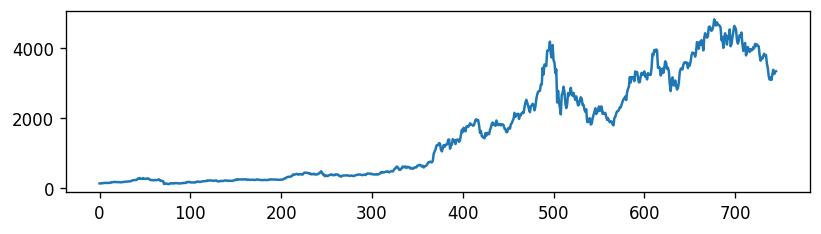

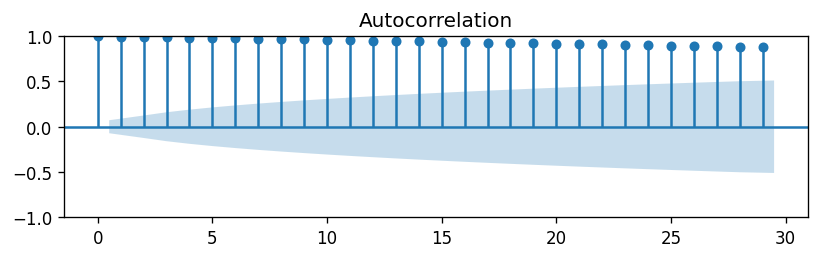

In [34]:
# Original Series

plt.plot(series.vals)
plot_acf(series.vals)

plt.show()

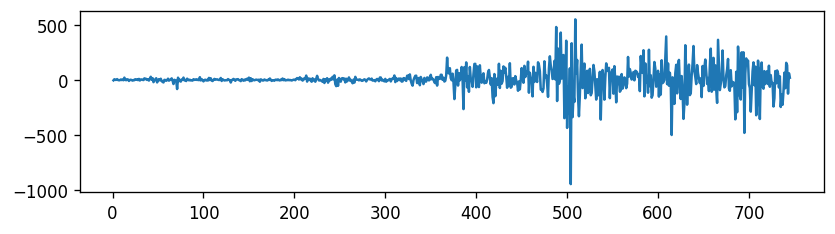

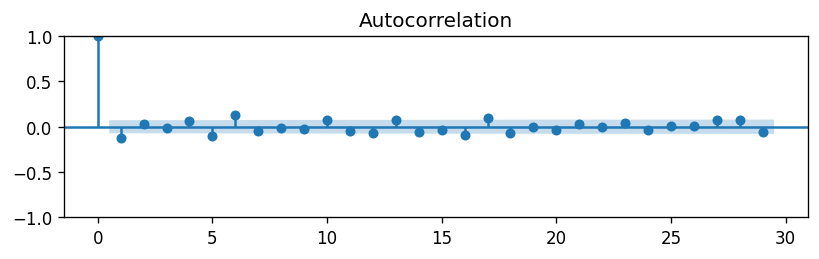

In [35]:
# 1st order differencing

plt.plot(series.vals.diff())
plot_acf(series.vals.diff().dropna())
plt.show()

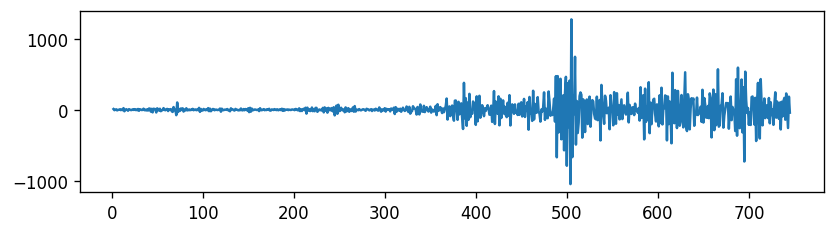

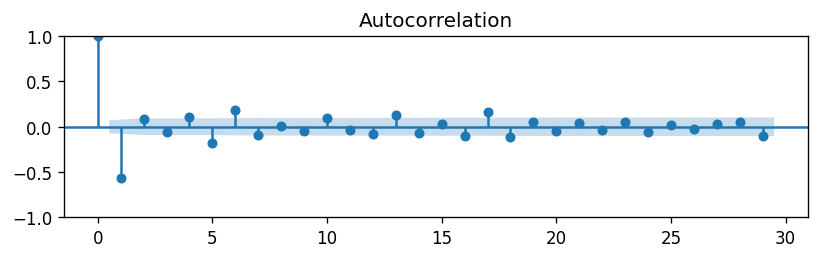

In [36]:
# 2nd order differencing

plt.plot(series.vals.diff().diff())
plot_acf(series.vals.diff().diff().dropna())
plt.show()

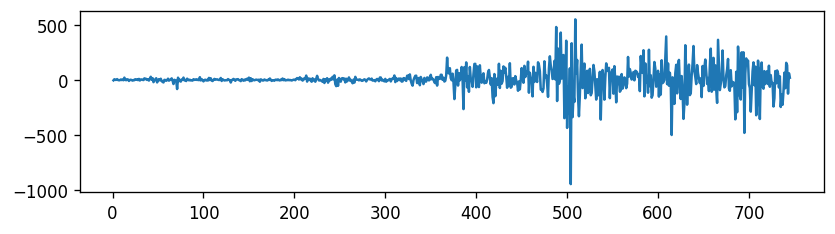

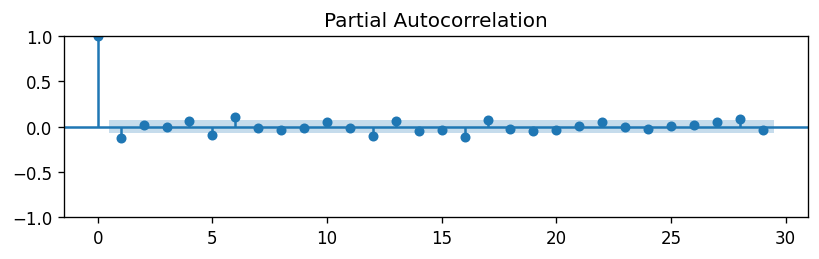

In [37]:
# For the above series, the time series reaches stationarity with two orders of differencing. But on 
# looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly 
# quick, which indicates, the series might have been over differenced.

# So, I am going to tentatively fix the order of differencing as 1 even though the series is not perfectly
# stationary (weak stationarity).

# Finding p:
plt.plot(series.vals.diff())

plot_pacf(series.vals.diff().dropna(), method='ywm')

plt.show()

# OUR p is 1

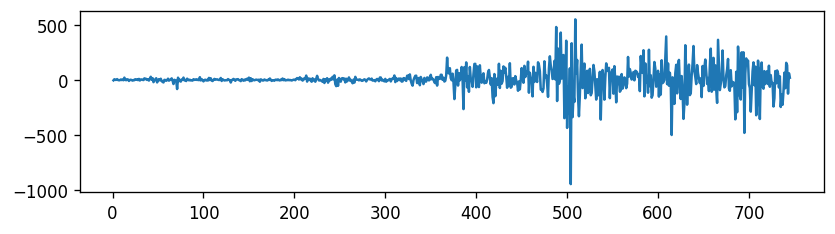

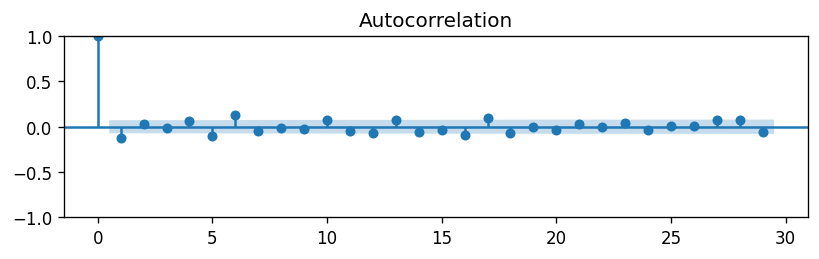

In [38]:
# We now find the q:
plt.plot(series.vals.diff())
plot_acf(series.vals.diff().dropna())

plt.show()

In [39]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,1 ARIMA Model
model = ARIMA(series.vals, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   vals   No. Observations:                  746
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4536.395
Date:                Mon, 17 Jan 2022   AIC                           9078.789
Time:                        19:41:41   BIC                           9092.630
Sample:                             0   HQIC                          9084.124
                                - 746                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8267      0.062    -13.247      0.000      -0.949      -0.704
ma.L1          0.7486      0.078      9.636      0.000       0.596       0.901
sigma2      1.139e+04    253.001     45.015      0.0

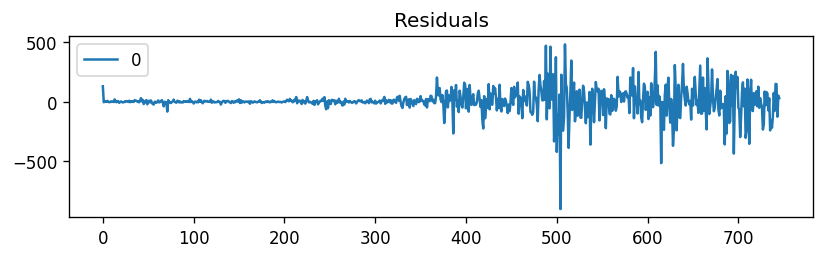

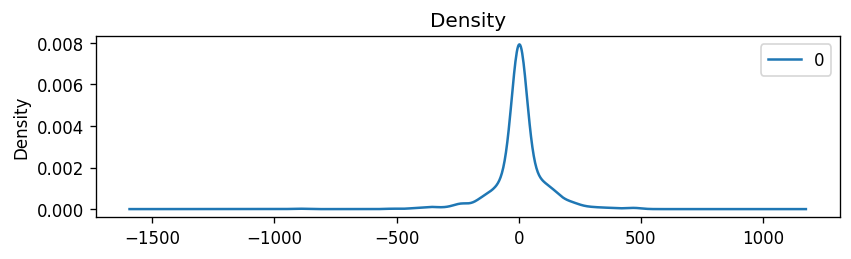

In [40]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)

residuals.plot(title="Residuals")
residuals.plot(kind='kde', title='Density')
plt.show()

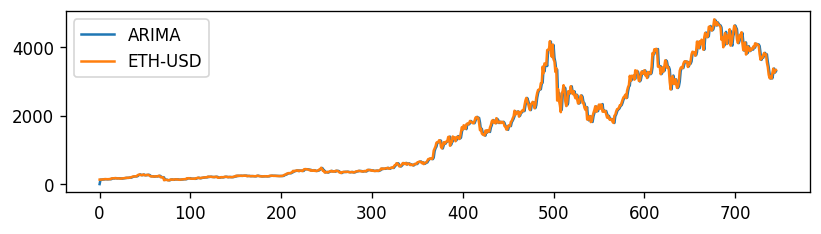

In [49]:
# Actual vs Fitted
plt.plot(model_fit.predict(dynamic=False), label = "ARIMA")
plt.plot(series.vals, label = "ETH-USD")
plt.legend(loc="upper left")
plt.show()

In [43]:
# Out of Sample prediction of price n days from now
model_fit.predict(len(series)+n)

749    3332.386593
dtype: float64

## Regime Detection

Idea: regime detection based both on post-panny sp500 data and complete since-2000 data (perhaps volatility conditions changed).

In [14]:
sp2000 = pdr.DataReader('SPY',data_source='yahoo' ,start='2000-01-01',end=datetime.date.today())[['Close']].dropna()
sp2020 = pdr.DataReader('SPY',data_source='yahoo' ,start='2020-01-01',end=datetime.date.today())[['Close']].dropna()

In [67]:
# add returns column
sp2000['Returns'] = np.log(sp2000['Close']/sp2000['Close'].shift(1))
sp2000 = sp2000[1:]
sp2020['Returns'] = np.log(sp2020['Close']/sp2020['Close'].shift(1))
sp2020 = sp2020[1:]

In [81]:
# Gaussian Learning
reg_detect = mix.GaussianMixture(n_components=4, covariance_type="spherical", n_init=100,random_state=42)
reg_detect_2020 = mix.GaussianMixture(n_components=4, covariance_type="spherical", n_init=100,random_state=42)

In [82]:
reg_detect.fit(np.reshape(sp2000,(-1,sp2000.shape[1])))
regime = reg_detect.predict(np.reshape(sp2000,(-1,sp2000.shape[1])))

reg_detect_2020.fit(np.reshape(sp2020,(-1,sp2020.shape[1])))
regime_2020 = reg_detect_2020.predict(np.reshape(sp2020,(-1,sp2020.shape[1])))

In [83]:
Regimes=pd.DataFrame(regime,columns=['Regime'],index=sp2000.index)\
                     .join(sp2000, how='inner')\
                          .assign(market_cu_return=sp2000.Returns.cumsum())\
                                 .reset_index(drop=False)\
                                             .rename(columns={'index':'Date'})
Regimes_2020 =pd.DataFrame(regime_2020,columns=['Regime'],index=sp2020.index)\
                     .join(sp2020, how='inner')\
                          .assign(market_cu_return=sp2020.Returns.cumsum())\
                                 .reset_index(drop=False)\
                                             .rename(columns={'index':'Date'})

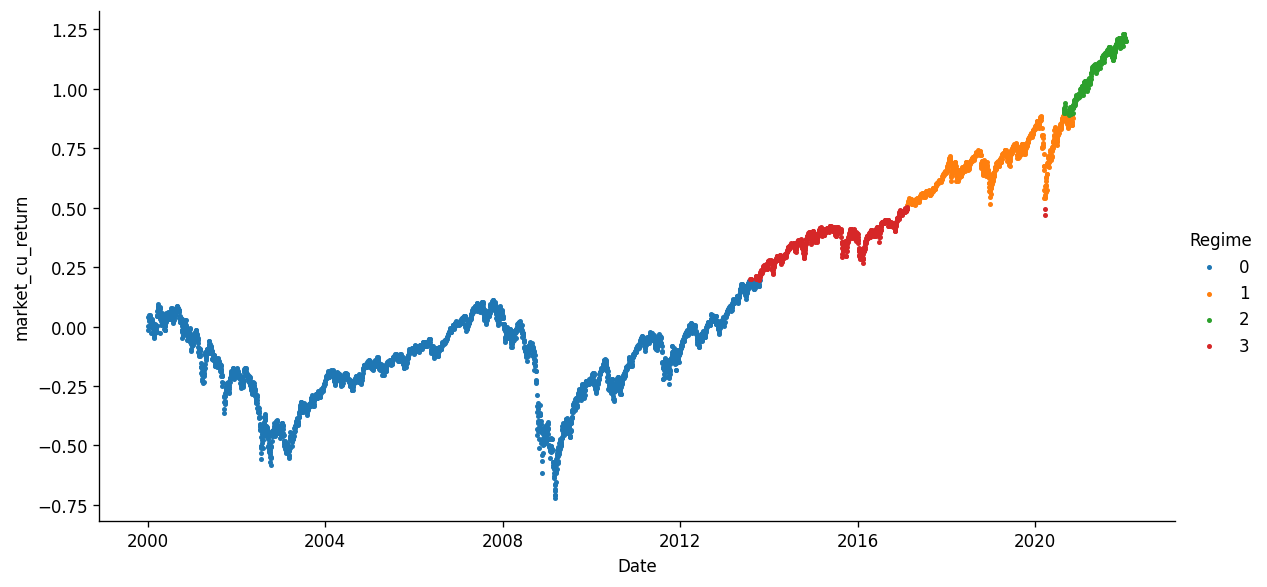

In [79]:
order=[0,1,2,3]
fig = seaborn.FacetGrid(data=Regimes,hue='Regime',hue_order=order,aspect=2,height= 5)
fig.map(plt.scatter,'Date','market_cu_return', s=4).add_legend()
plt.show()

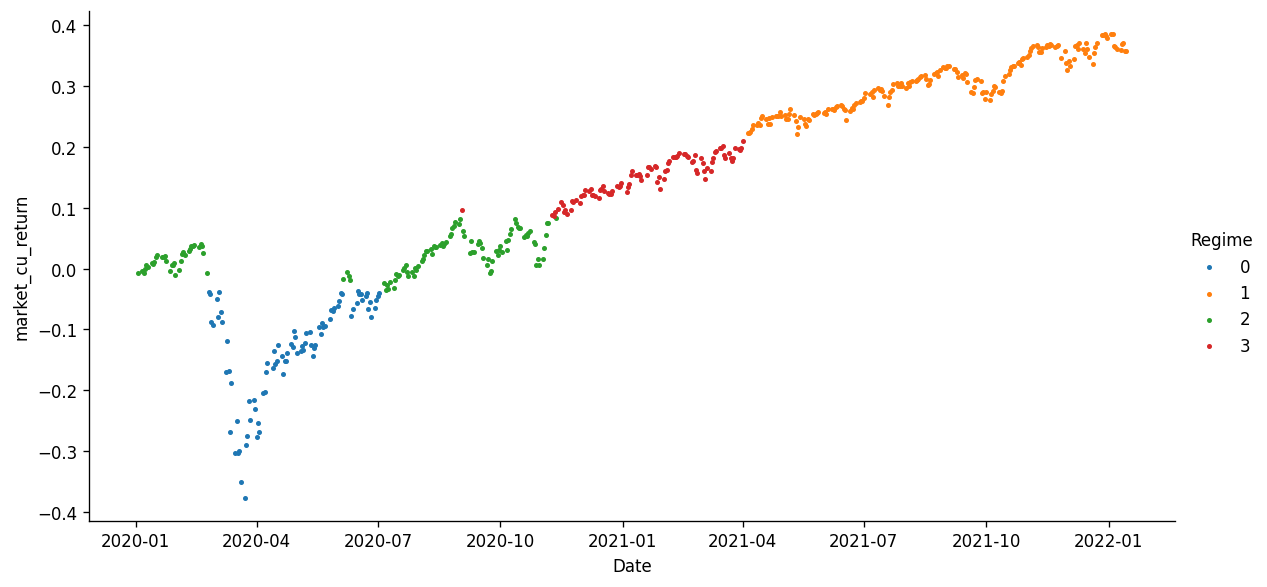

In [84]:
order=[0,1,2,3]
fig = seaborn.FacetGrid(data=Regimes_2020,hue='Regime',hue_order=order,aspect=2,height= 5)
fig.map(plt.scatter,'Date','market_cu_return', s=4).add_legend()
plt.show()

In [110]:
# Compare S&P500 returns with ETH-USD
eth2020 = pdr.DataReader('ETH-USD',data_source='yahoo' ,start='2020-01-01',end=datetime.date.today())[['Close']].dropna()
eth2020['ETH_Returns'] = np.log(eth2020['Close']/eth2020['Close'].shift(1))
eth2020 = eth2020[1:]

eth2020.drop(columns=['Close'])
sp2020.drop(columns=['Close'])
eth2020

,Close,ETH_Returns
Date,,
2020-01-02,127.410179,-0.026273
2020-01-03,134.171707,0.051709
2020-01-04,135.069366,0.006668
2020-01-05,136.276779,0.008899
2020-01-06,144.304153,0.057235
...,...,...
2022-01-13,3248.288574,-0.037454
2022-01-14,3310.001465,0.018820
2022-01-15,3330.530762,0.006183


In [107]:
eth2020 = eth2020.merge(sp2020, how="right")



In [108]:
eth2020


,Close,ETH_Returns,Returns
0,322.410004,NaN,-0.007601
1,323.640015,NaN,0.003808
2,322.730011,NaN,-0.002816
3,324.450012,NaN,0.005315
4,326.649994,NaN,0.006758
...,...,...,...
509,465.510010,NaN,-0.001245
510,469.750000,NaN,0.009067
511,471.019989,NaN,0.002700
512,464.529999,NaN,-0.013874


In [109]:
# delete?
steps = [('scaler',StandardScaler()),
         ('lasso',Lasso())]        

pipeline = Pipeline(steps)


parameters = {'lasso__alpha':np.arange(0.0001,10,.0001),
              'lasso__max_iter':np.random.uniform(100,100000,4)}


reg = rcv(pipeline, parameters,cv=5)